In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import psutil
from functools import reduce
from tqdm import tqdm_notebook
from multiprocessing import Process
from numpy.fft import rfft, rfftfreq, irfft
import gen_features
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Read in a train chunk

In [4]:
### Read training sets and confirm indices
k=2
data = pd.read_csv(os.path.join("Data","train_chunk{0}.csv".format(k))).iloc[:,1:]

segment_list = []
for i in range(int(np.floor(data.shape[0]/150000))):
    start = i*150000
    stop = (i+1)*150000
    segment_list.append(data.loc[start:stop])

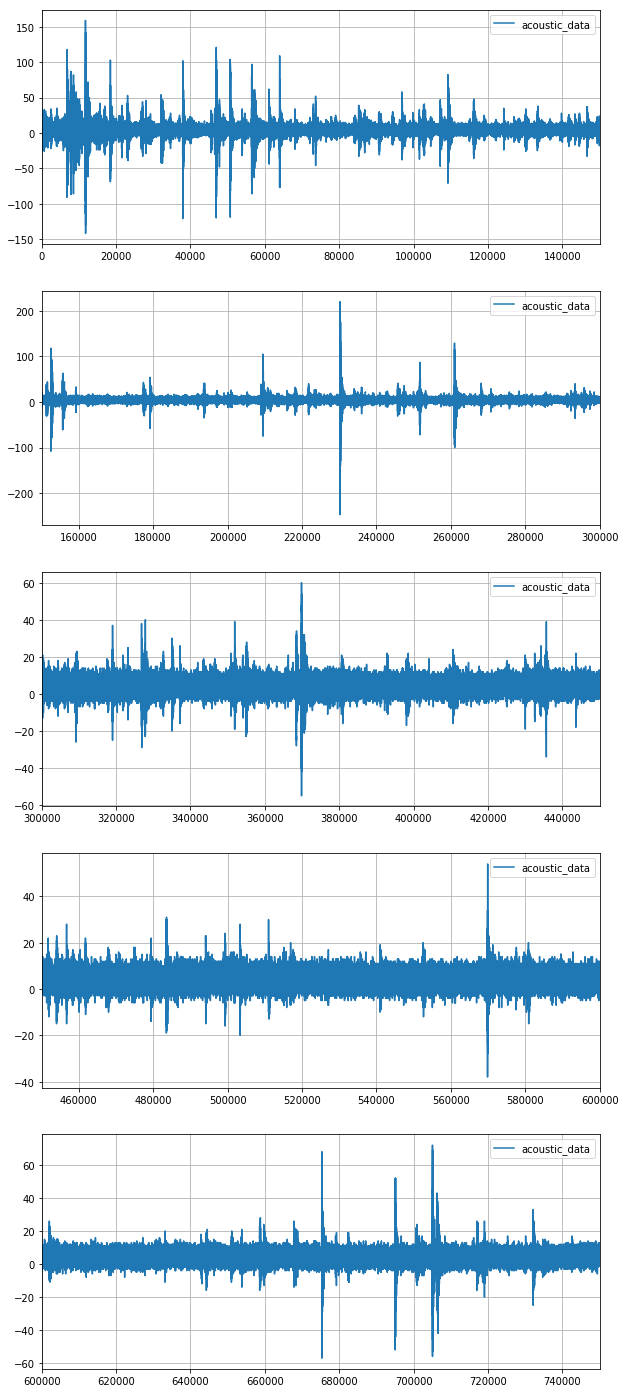

In [5]:
nrows = min(5,len(segment_list))
fig, axes = plt.subplots(nrows,1,figsize=(10,5*nrows))
for segment,axis in zip(segment_list,axes):
    axis.plot(segment.index,segment['acoustic_data'])
    axis.legend()
    axis.grid()
    axis.set_xlim((segment.index[0],segment.index[-1]))

### Generate and plot ffts

In [29]:
freq = rfftfreq(150000,d=1/4e6)
fft_list = [rfft(segment['acoustic_data']) for segment in segment_list]
low_pass_freq = 2e5 #5e5
high_pass_freq = 1e4
lp_fft_list = [fft*(freq<low_pass_freq) for fft in fft_list]
lp_segment_list = [irfft(lp_fft,150000) for lp_fft in lp_fft_list]
hp_fft_list = [fft*(freq>high_pass_freq) for fft in fft_list]
hp_segment_list = [irfft(hp_fft,150000) for hp_fft in hp_fft_list]
roll_fft_list = [rfft(segment['acoustic_data'].rolling(10).mean()[10:]) for segment in segment_list]
roll_freq = rfftfreq(len(segment['acoustic_data'].rolling(10).mean()[10:]),d=1/4e6)

Text(0.5, 1.0, 'Rolling Mean vs Regular FFTs')

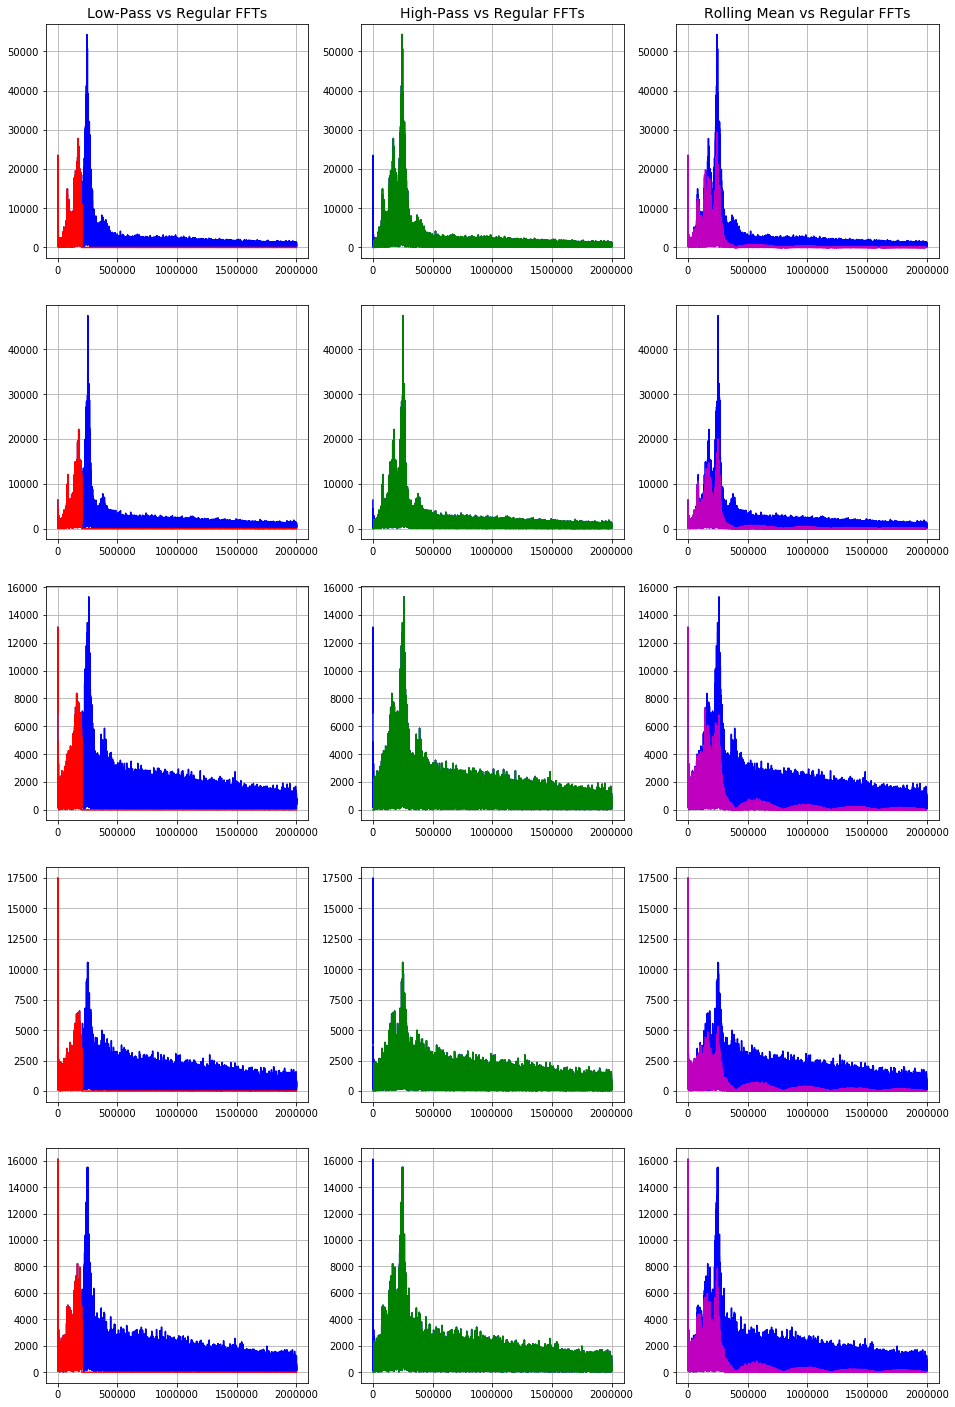

In [30]:
nrows = min(5,len(segment_list))
fig, axes = plt.subplots(nrows,3,figsize=(16,5*nrows))
for fft,lp_fft,hp_fft,roll_fft,axis in zip(fft_list,lp_fft_list,hp_fft_list,roll_fft_list,axes):
    axis[0].plot(freq[1:],np.abs(fft[1:]),'b')
    axis[0].plot(freq[1:],np.abs(lp_fft[1:]),'r')
    axis[0].grid()
    
    axis[1].plot(freq[1:],np.abs(fft[1:]),'b')
    axis[1].plot(freq[1:],np.abs(hp_fft[1:]),'g')
    axis[1].grid()
    
    axis[2].plot(freq[1:],np.abs(fft[1:]),'b')
    axis[2].plot(roll_freq[1:],np.abs(roll_fft[1:]),'m')
    axis[2].grid()

axes[0,0].set_title('Low-Pass vs Regular FFTs',fontsize=14)
axes[0,1].set_title('High-Pass vs Regular FFTs',fontsize=14)
axes[0,2].set_title('Rolling Mean vs Regular FFTs',fontsize=14)

### Return low/high pass filtered segments, and compare with simple rolling mean segments

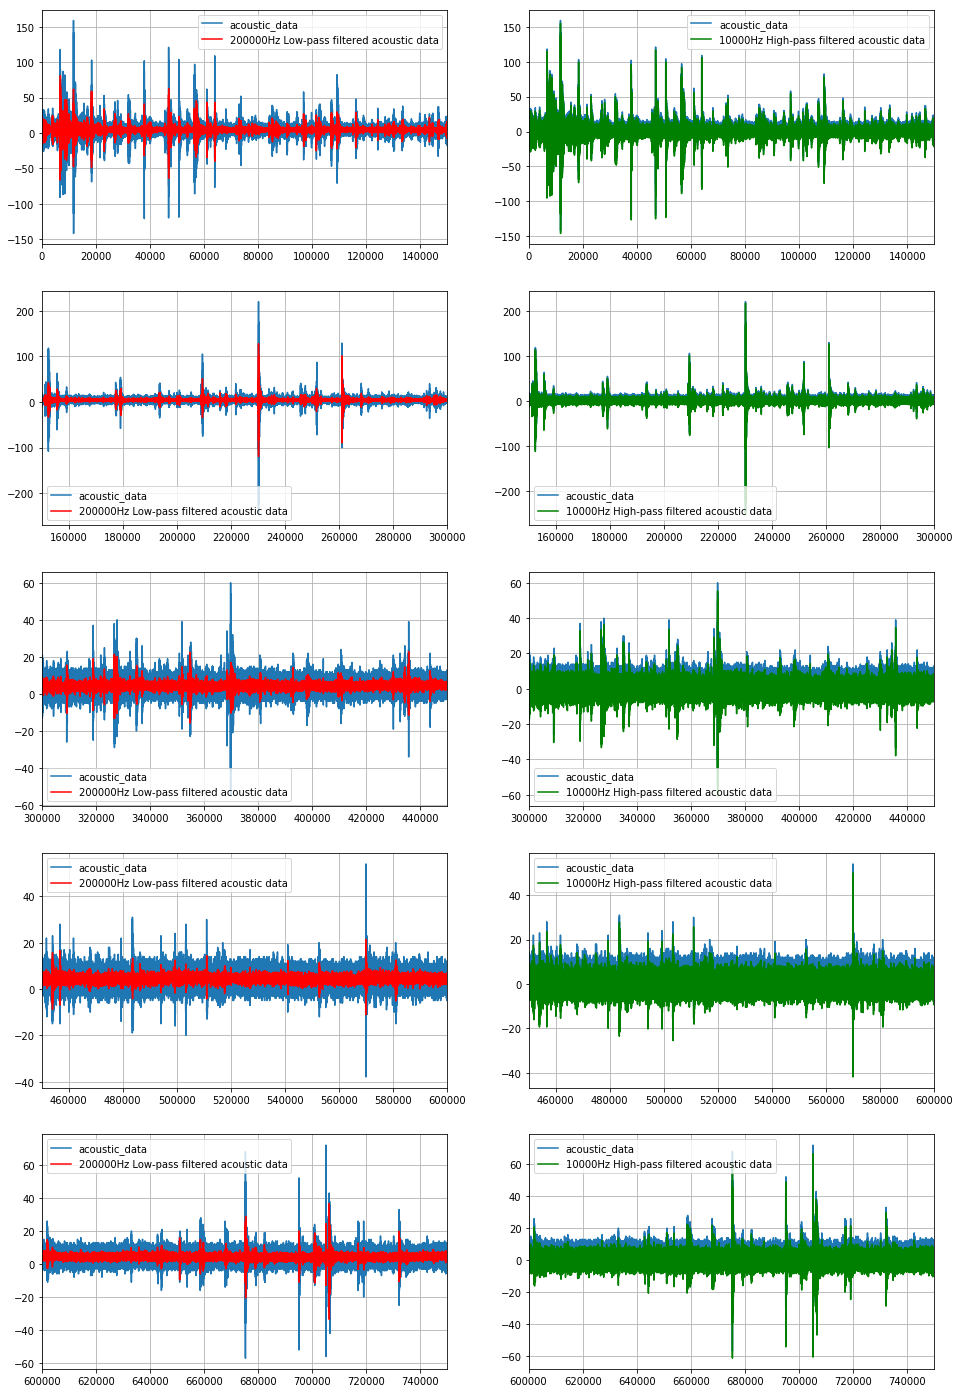

In [31]:
fig, axes = plt.subplots(nrows,2,figsize=(16,5*nrows))
for segment,lp_segment,hp_segment,axis in zip(segment_list,lp_segment_list,hp_segment_list,axes):
    axis[0].plot(segment.index,segment['acoustic_data'])
    axis[0].plot(segment.index[:-1],lp_segment,'r', label = "{:.0f}Hz Low-pass filtered acoustic data".format(low_pass_freq))
    axis[0].legend()
    axis[0].grid()
    axis[0].set_xlim((segment.index[0],segment.index[-1]))
    
    axis[1].plot(segment.index,segment['acoustic_data'])
    axis[1].plot(segment.index[:-1],hp_segment, 'g', label = "{:.0f}Hz High-pass filtered acoustic data".format(high_pass_freq))
    axis[1].legend()
    axis[1].grid()
    axis[1].set_xlim((segment.index[0],segment.index[-1]))

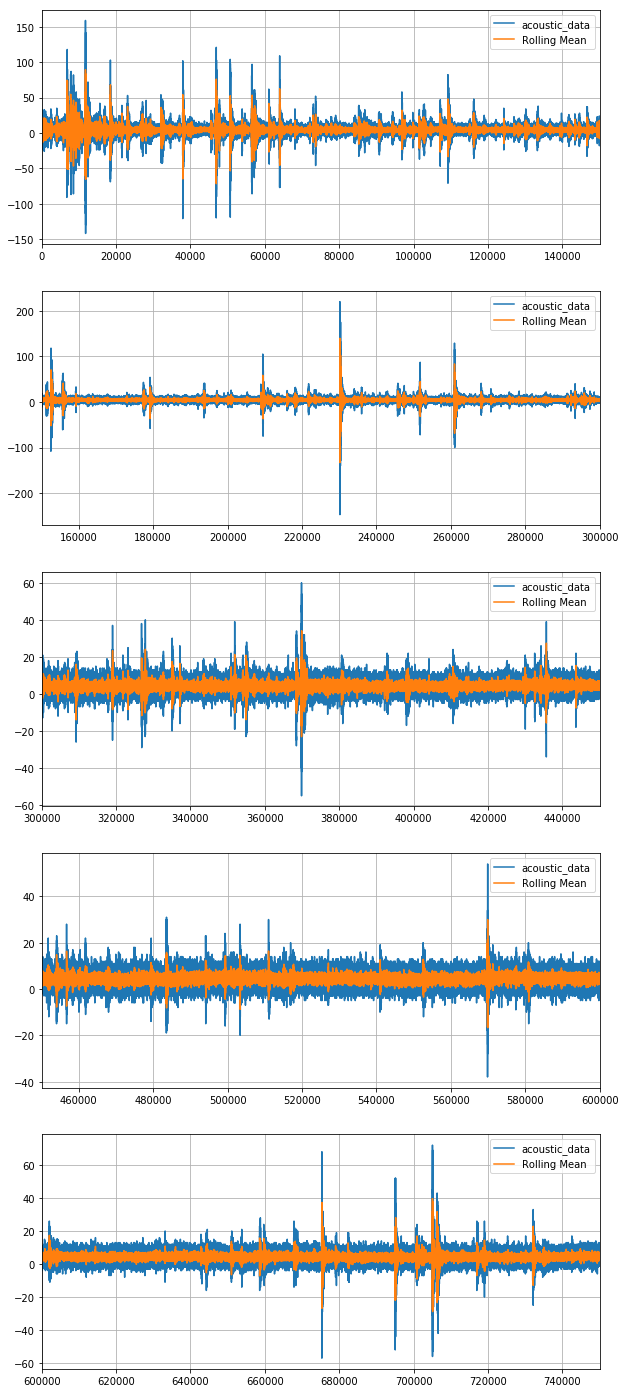

In [9]:
fig, axes = plt.subplots(nrows,1,figsize=(10,5*nrows))
for segment,axis in zip(segment_list,axes):
    axis.plot(segment.index,segment['acoustic_data'])
    axis.plot(segment.index,segment['acoustic_data'].rolling(10).mean(), label = "Rolling Mean")
    axis.legend()
    axis.grid()
    axis.set_xlim((segment.index[0],segment.index[-1]))